In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Calibration
## Preparation of input data
This notebook prepares input data from the dataset "[Mobilität in Deutschland 2017](http://www.mobilitaet-in-deutschland.de/) B2" (MiD2017) for model calibration. The German Federal Ministry of Transport and Digital Infrastructure is copyright holder of this dataset and does not allow any form of publication.

In [2]:
input_path = '../input/transport_demand/'

### What are calibration data requirements?
The mathematical formulation of the discrete choice model defines the requirements:
> V = T • β_t + β_cost • C • SU + β_access • AC

Note: All parameters are demand group specific. The model formulation for each mode is the same, even though some variables are zero.

The MiD2017 trips table builds the calibration dataset with the following columns:
*	start cell (KKZ_SO)
*	end cell (KKZ_ZO)
*	cell urbanisation (SKTYP)
*	trip distance [km] (wegkm_imp)
*	trip distance routed MiD grouped [km] (km_routing_gr)
*	trip duration [min] (wegmin_imp1)
*	trip purpose (hwzweck1); return trips reference the original trip purpose, holiday is not specified but part of private
*	main mode (hvm_diff2)
*	mode combination (vm_kombi)
*	number of travellers (anzpers)
*	car available in household (auto)
*	public transport ticket type or subscription (P_FKARTE)
*	mode affinity of person (multimodal)
*	distance to the next train station from home (bahn28)
*	distance to the next bus stop from home (bus28)
*	distance to the next train station at destination (bahn28_zo)
*	distance to the next bus stop at destination (bus28_zo)

Rows (trips) are filtered for the following criteria:
1.	Only trips with detailed specifications
2.	Only inner-German trips
3.	Only over-regional traffic (trip start cell different to end cell) 
4.	Value of each column is specified
6.  Remove ferries


In [3]:
trips = pd.read_csv(input_path + 'MiD2017_Regional_Wege.csv', sep=';')
print(trips.shape)

(960619, 157)


In [4]:
trips = trips[['KKZ_SO', 'KKZ_ZO', 'SKTYP', 'wegkm_imp', 'km_routing_gr',
               'wegmin_imp1', 'hwzweck1', 'hvm_diff2', 'vm_kombi', 'anzpers',
               'auto', 'P_FKARTE', 'multimodal', 'bahn28', 'bus28', 'bahn28_zo',
               'bus28_zo', 'W_DETAIL', 'W_SO2']]
trips.columns = ['origin', 'destination', 'SKTYP', 'distance', 'distance_routed',
                 'duration', 'purpose', 'mode', 'mode_combo', 'n_persons',
                 'car_avail', 'ticket_type', 'mode_affinity', 'dist_train_origin',
                 'dist_bus_origin', 'dist_train_destination', 'dist_bus_destination',
                 'W_DETAIL', 'W_SO2']

In [5]:
trips['distance'] = pd.to_numeric(trips['distance'].str.replace(',', '.'))

In [6]:
#trips.head(10)

In [7]:
# Filter for trip details
trips = trips.loc[trips['W_DETAIL']!=0]
print(trips.shape)

(908497, 19)


In [8]:
# Filter for inner-German trips
trips = trips.loc[(trips['W_SO2']!=2) & (trips['W_SO2']!=3)]
print(trips.shape)

(907678, 19)


In [9]:
# Filter unspecified rows
trips = trips.loc[(trips['purpose']!=99) &
                  (trips['origin']<9999) &
                  (trips['destination']<9999) &
                  (trips['mode']<24)]
print(trips.shape)

(409507, 19)


In [10]:
# Filter for inter-cellular traffic
trips = trips.loc[trips['origin']!=trips['destination']]
print(trips.shape)

(108887, 19)


In [11]:
# Filter for longer trips (taking routed distance)
trips = trips.loc[~trips['distance_routed'].isin([1,2,3])]
print(trips.shape)

(108374, 19)


In [11]:
# Remove air travel
#trips = trips.loc[trips['mode']!=23]
#print(trips.shape)

In [12]:
# Remove ferries
trips = trips.loc[trips['mode']!=19]
print(trips.shape)

(108338, 19)


In [13]:
# Make unknown number of persons equal to one
trips.loc[trips['n_persons']>6] = 1

In [14]:
# Convert distances to integer kilometers
dist_dict = {1:1, 2:1, 3:1, 4:2, 5:4, 6:6, 95:20, 701:20}
trips['dist_train_origin'] = trips['dist_train_origin'].map(dist_dict)
trips['dist_bus_origin'] = trips['dist_bus_origin'].map(dist_dict)
trips['dist_train_destination'] = trips['dist_train_destination'].map(dist_dict)
trips['dist_bus_destination'] = trips['dist_bus_destination'].map(dist_dict)

In [15]:
# Convert routed distances to integer km
routed_dist_dict = {1:1, 2:1, 3:1, 4:4, 5:8, 6:15, 7:35, 8:75, 9:100, 95:0, 701:0, 703:0, 706:0, 708:0}
trips['distance_routed'] = trips['distance_routed'].map(routed_dist_dict)

In [16]:
# Align regional specifics with urbanisation degree
mid_urbanisation_dict = {1:1, 2:1, 3:2, 4:3}
trips['urbanisation'] = trips['SKTYP'].map(mid_urbanisation_dict)

In [17]:
# Match trip purpose with VP2030 categories
# Note: Holiday trips are included in private (6)
purpose_mid_vp_dict = {1: 1, 2: 4, 3: 2, 4: 3, 5: 3, 6: 6, 7: 6, 99: 6}
trips['purpose_vp'] = trips['purpose'].map(purpose_mid_vp_dict)

In [18]:
# Match mode with the model modes
# Non-motorised modes are merged
model_modes = {1: 'rail_short_distance', 2: 'rail_long_distance',
               3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mode_mid_vp_dict = {1:7, 2:7, 3:7, 4:6, 5:6, 6:6, 7:6, 8:6,
                    9:6, 10:6, 11:6, 12:4, 13:4, 14:4, 15:4,
                    16:1, 17:6, 18:6, 19:6, 20:2, 21:3, 22:3,
                    23:5, 24:7}
trips['mode_model'] = trips['mode'].map(mode_mid_vp_dict)

## Visualise the dataset specifics
Note: This dataset does not represent average mobility behaviour but trips that are selected to fit the research question of the model being built

In [19]:
# Average speed in km/h
t = trips.copy()
t['speed'] = t['distance'] / (t['duration'] / 60)
t.groupby('mode_model').agg({'speed': 'mean'})

,speed
mode_model,
1,30.120684
2,76.872591
3,46.875766
4,18.629248
5,337.085255
6,44.122442
7,17.009194


In [20]:
# Average travel group size
for i, mode in model_modes.items():
    print(mode + ': ' + str(trips.loc[trips['mode_model']==i]['n_persons'].mean()))

rail_short_distance: 1.5345052083333333
rail_long_distance: 1.6607538802660753
coach: 3.199203187250996
bus: 1.7913385826771653
air: 2.269230769230769
car: 1.7726942628903413
walk: 1.6483790523690773


car: y=0.0024*x+1.693
walk: y=0.0174*x+1.583
bus: y=0.0137*x+1.609
rail_short_distance: y=0.0063*x+1.343
rail_long_distance: y=0.0011*x+1.441
air: y=-0.0002*x+2.356
coach: y=0.0006*x+3.137


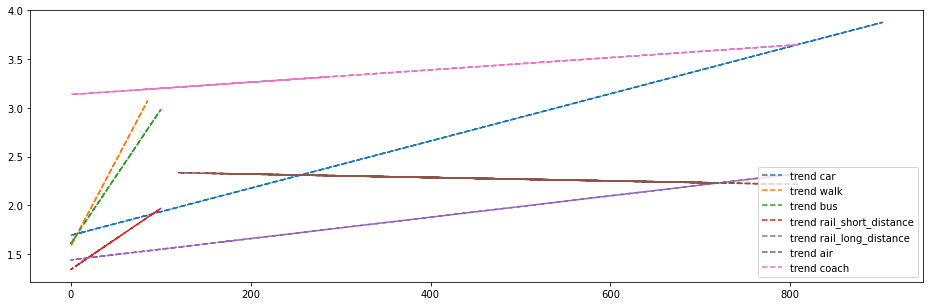

In [21]:
# Distance-dependency of occupation factors
fig, ax = plt.subplots(figsize=(16,5))
for mode in trips['mode_model'].unique():
    x = trips.loc[trips['mode_model']==mode, 'distance']
    y = trips.loc[trips['mode_model']==mode, 'n_persons']
    #plt.scatter(x, y, marker='x', alpha=.1, label=mode)
    z = np.polyfit(x, y, deg=1)
    p = np.poly1d(z)
    plt.plot(x, p(x), linestyle='--', marker='', label='trend '+model_modes[mode])
    print('{}: y={}*x+{}'.format(model_modes[mode], np.round(z[0], 4), np.round(z[1], 3)))
plt.legend()

<AxesSubplot:title={'center':'Sample size by trip purpose (VP2030)'}, xlabel='purpose_vp'>

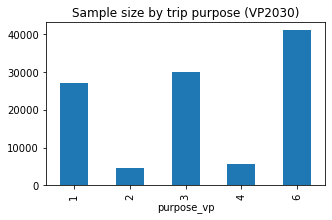

In [22]:
# Sample size per trip purpose
trips.groupby('purpose_vp').size().plot.bar(
    figsize=(5, 3), title='Sample size by trip purpose (VP2030)',
    legend=False)

### Distance
This is relevant for calculation of trip cost

<AxesSubplot:title={'center':'Trip distance distribution, logarithmic'}, ylabel='Frequency'>

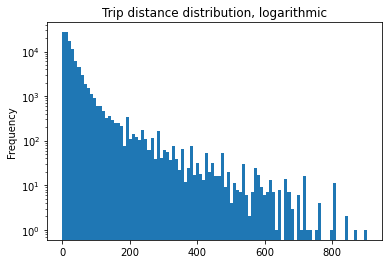

In [23]:
# Trip distance
trips['distance'].plot.hist(bins=100, log=True,
                            title='Trip distance distribution, logarithmic')

The majority of trips is under 30km

                  distance
distance_routed           
0                24.947040
1                 1.000000
4                 5.203717
8                 8.706908
15               15.763399
35               31.716445
75               61.217946
100              91.830774
count    108338.000000
mean         32.912057
std          54.893710
min           0.010000
25%           9.410000
50%          18.240000
75%          34.200000
max         902.500000
Name: distance, dtype: float64


C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

<AxesSubplot:xlabel='distance', ylabel='duration'>

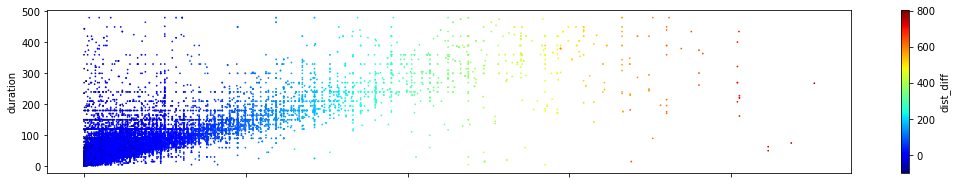

In [24]:
# Distance validation
# The routed distance is intended to validate the MiD2017 respondent's distance estimations
# High standard deviation is a bad sign for the respondent's estimation capabilities but
# contributes to the validity of the distance-related calibration factor of the model estimation.
# We can only validate categories 1 to 75.
print(trips.groupby('distance_routed').agg({'distance':'mean'}))
print(trips['distance'].describe())
t['dist_diff'] = t['distance'] - t['distance_routed']
t.loc[t['distance_routed'].isin([1,4,8,15,35,75,100])].plot.scatter(
    'distance', 'duration', s=.5, c='dist_diff', colormap='jet', figsize=(18, 3))

Conclusion from this plot: The respondent's distance and duration become more implausible with higher distances and higher durations.

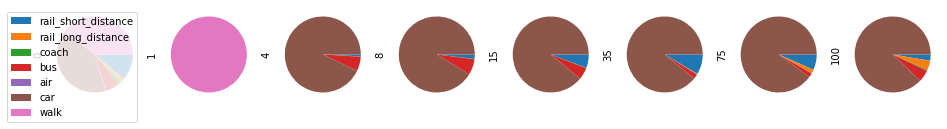

In [25]:
# Modal split by distance group
# Group 0 has no information
axs = trips.groupby(['mode_model','distance_routed']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 4), labels=[m for _, m in model_modes.items()],
    startangle=0, counterclock=False, legend=None, labeldistance=None)
axs[0].legend()

### Duration
Usually the most influencive factor for mode choice

<AxesSubplot:title={'center':'Trip duration distribution, logarithmic'}, ylabel='Frequency'>

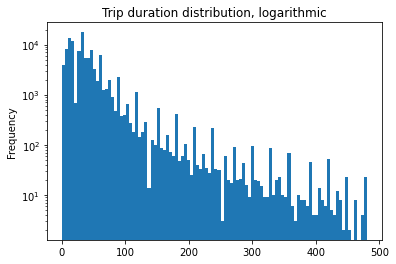

In [26]:
# Trip duration
trips['duration'].plot.hist(bins=100, log=True, title='Trip duration distribution, logarithmic')

The majority of trips is under 1h but the distribution is less steep than the one of distance. Unregularities come from the respondent's tendency to state full, half or quarter hours.

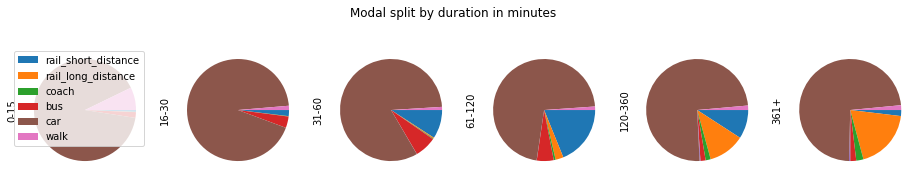

In [27]:
# Modal split by duration
t['bins'] = pd.cut(t['duration'], bins=[0,15,30,60,120,360,500],
                   labels=["0-15", "16-30","31-60","61-120","120-360","361+"])
axs = t.groupby(['mode_model','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3), labels=[m for _, m in model_modes.items()],
    startangle=0, counterclock=False, title='Modal split by duration in minutes',
    legend=False, labeldistance=None)
axs[0].legend()

<AxesSubplot:title={'center':'Duration in minutes'}, ylabel='None'>

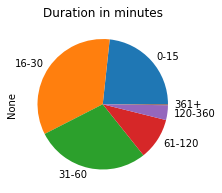

In [28]:
# Distribution
t.groupby('bins').size().plot.pie(subplots=False,figsize=(3, 3),
                                  title='Duration in minutes')
                                  #colormap=rli)
#plt.savefig('figd.png', dpi=300)

### Trip purpose
Adjusted to VP2030 with holiday trips being part of private

<AxesSubplot:title={'center':'share of trips by purpose'}, ylabel='None'>

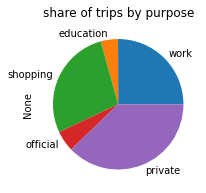

In [29]:
# Trip purpose
trips.groupby('purpose_vp').size().plot.pie(subplots=False,figsize=(3, 3),
                                           labels=['work', 'education', 'shopping', 'official', 'private'],
                                           title='share of trips by purpose')

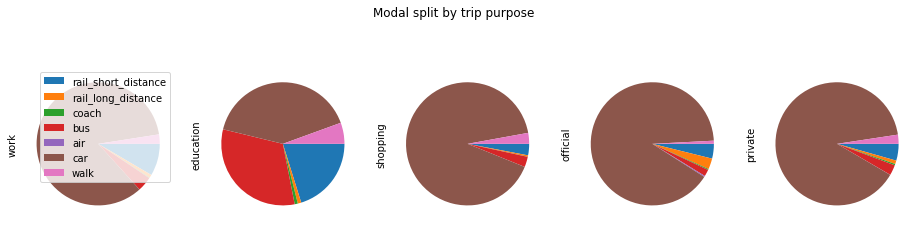

In [30]:
# Modal split
axs = trips.groupby(['mode_model','purpose_vp']).size().unstack(fill_value=0).rename(
    columns={1:'work', 2:'education', 3:'shopping', 4:'official', 6:'private'}).plot.pie(
    subplots=True, figsize=(16, 4), labels=[m for _, m in model_modes.items()],
    startangle=0, counterclock=False, title='Modal split by trip purpose',
    legend=False, labeldistance=None)
axs[0].legend()

array([<AxesSubplot:ylabel='work'>, <AxesSubplot:ylabel='education'>,
       <AxesSubplot:ylabel='shopping'>, <AxesSubplot:ylabel='official'>,
       <AxesSubplot:ylabel='private'>], dtype=object)

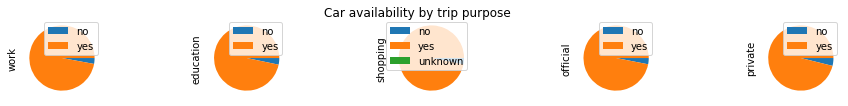

In [31]:
# Car availability
trips.groupby(['car_avail','purpose_vp']).size().unstack(fill_value=0).rename(
columns={1:'work', 2:'education', 3:'shopping', 4:'official', 6:'private'}).plot.pie(
    subplots=True, figsize=(16, 1.5), labels=['no', 'yes', 'unknown'],
    labeldistance=None, startangle=0, counterclock=False, title='Car availability by trip purpose')

### Ticket types
Which kind of ticket do people use for public transport?

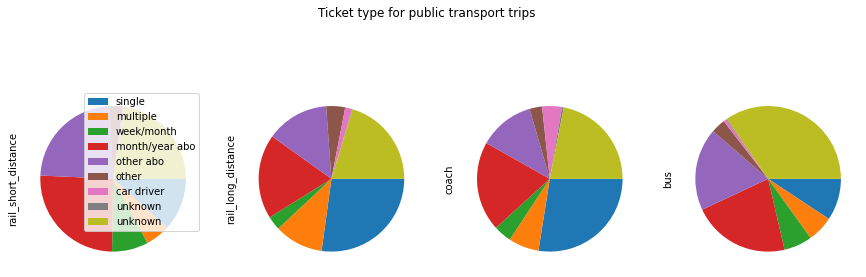

In [32]:
# PT ticket type
axs = trips.loc[trips['mode_model'].isin([1,2,3,4])].groupby(
    ['ticket_type', 'mode_model']).size().unstack(fill_value=0).rename(
    columns={i: model_modes[i] for i in range(1,5)}).plot.pie(
    subplots=True, figsize=(15, 5), labels=['single', 'multiple', 'week/month',
                                           'month/year abo', 'other abo', 'other',
                                           'car driver', 'unknown', 'unknown'],
    labeldistance=None, startangle=0, counterclock=False, legend=None,
    title='Ticket type for public transport trips')
axs[0].legend()

In [33]:
# Share of abonements
for mode, name in model_modes.items():
    n = len(trips.loc[trips['mode_model']==mode].index)
    print(name + ': ' + str(len(trips.loc[
        (trips['mode_model']==mode) &
        trips['ticket_type'].isin([4,5])].index) / n))

rail_short_distance: 0.4899088541666667
rail_long_distance: 0.3270509977827051
coach: 0.32270916334661354
bus: 0.399825021872266
air: 0.19230769230769232
car: 0.06697210474603785
walk: 0.14748842180263627


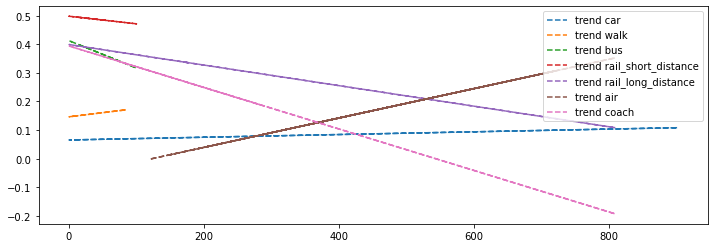

In [34]:
# Distance-dependency of abonements
fig, ax = plt.subplots(figsize=(12,4))
for mode in trips['mode_model'].unique():
    x = trips.loc[trips['mode_model']==mode, 'distance']
    y = trips.loc[trips['mode_model']==mode, 'ticket_type'].apply(lambda t: t in [4,5])
    z = np.polyfit(x, y, deg=1)
    p = np.poly1d(z)
    plt.plot(x, p(x), linestyle='--', marker='', label='trend '+model_modes[mode])
plt.legend()

### Regional classification
Differences between poeple who live in cities vs. rural sites

Important: This does always specify the cell of household location

<AxesSubplot:title={'center':'Urbanisation degree of home cell'}, ylabel='None'>

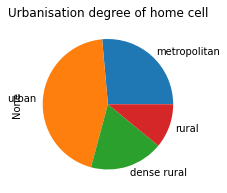

In [35]:
# Urbanisation
trips.groupby('SKTYP').size().plot.pie(subplots=False,figsize=(3, 3),
                                       labels=['metropolitan', 'urban', 'dense rural', 'rural'],
                                       title='Urbanisation degree of home cell')

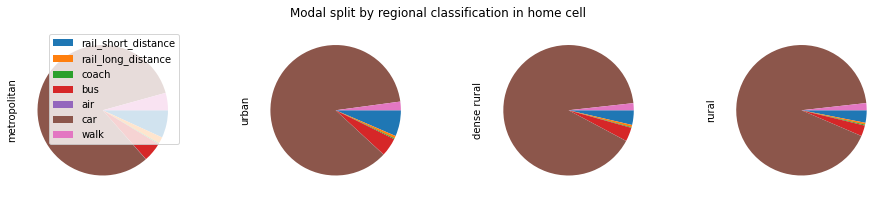

In [36]:
# Mode choice by regional classification
axs = trips.groupby(['mode_model','SKTYP']).size().unstack(fill_value=0).rename(
    columns={1:'metropolitan', 2:'urban', 3:'dense rural', 4:'rural'}).plot.pie(
    subplots=True, figsize=(16, 3), labels=[m for _, m in model_modes.items()],
    startangle=0, counterclock=False, title='Modal split by regional classification in home cell',
    legend=False, labeldistance=None)
axs[0].legend()

C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec()

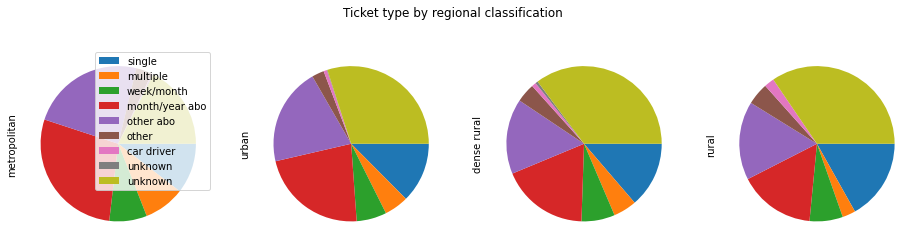

In [37]:
# PT trips' ticket type by regional classification
axs = trips.loc[trips['mode_model'].isin([1,2,3,4])].groupby(
    ['ticket_type', 'SKTYP']).size().unstack(fill_value=0).rename(
    columns={1:'metropolitan', 2:'urban', 3:'dense rural', 4:'rural'}).plot.pie(
    subplots=True, figsize=(16, 4), labels=['single', 'multiple', 'week/month',
                                           'month/year abo', 'other abo', 'other',
                                           'car driver', 'unknown', 'unknown'],
    labeldistance=None, startangle=0, counterclock=False, legend=None,
    title='Ticket type by regional classification')
axs[0].legend()

## Save dataset

In [38]:
trips.to_csv(input_path + 'calibration_inter-cellular_trips_MiD2017.csv')